# Brest cancer classifier

In [2]:
import os
import glob
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from tensorflow.keras import layers, models, optimizers, callbacks, metrics

## Pre-processing

#### Gathers image paths and extracts patient IDs & labels.


In [3]:
ROOT_DIR = '../Data/'

records = []
for pid in os.listdir(ROOT_DIR):
    pdir = os.path.join(ROOT_DIR, pid)
    if not os.path.isdir(pdir):
        continue
    for label in ['0', '1']:
        ldir = os.path.join(pdir, label)
        if not os.path.isdir(ldir):
            continue
        for ext in ('png', 'jpg', 'jpeg'):
            for path in glob.glob(os.path.join(ldir, f'*.{ext}')):
                records.append({'path': path,
                                'patient_id': pid,
                                'label': int(label)})

the code above traverses our data/ folder as shown in this Tree, taking the ``path`` of the 50x50 patch, the ``patient_id`` of this patch and its ``class``.

```
data/
└── IDC_regular_ps50_idx5/
    ├── 10253/
    │   ├── 0/
    │   └── 1/
    ├── 10254/
    │   ├── 0/
    │   └── 1/
    … etc.

```

In [4]:
df = pd.DataFrame(records)

df.head()

,path,patient_id,label
0,../Data/10268/0/10268_idx5_x2501_y1901_class0.png,10268,0
1,../Data/10268/0/10268_idx5_x1851_y1101_class0.png,10268,0
2,../Data/10268/0/10268_idx5_x1451_y1251_class0.png,10268,0
3,../Data/10268/0/10268_idx5_x3451_y1201_class0.png,10268,0
4,../Data/10268/0/10268_idx5_x901_y1751_class0.png,10268,0


#### Splits patients into train/val/test sets.



In [5]:
from sklearn.model_selection import train_test_split

patients = df['patient_id'].unique()

train_p, temp_p = train_test_split(patients, test_size=0.30, random_state=42)

val_p, test_p  = train_test_split(temp_p, test_size=0.50, random_state=42)

# so here we have train_patients, val_patients, test_patients 70%, 15%, 15%



Patient‐level splits block any overlap of tissue artifacts between training and testing, ensuring the model truly generalizes to new patients—so our reported sensitivity (recall) and predictive‐value (précision) scores reflect real‐world clinical performance.

In [6]:

# Filter the original DataFrame to create each split
train_df = df[df['patient_id'].isin(train_p)].reset_index(drop=True)
val_df   = df[df['patient_id'].isin(val_p)].reset_index(drop=True)
test_df  = df[df['patient_id'].isin(test_p)].reset_index(drop=True)

print(f"Train patients: {len(train_p)}, patches: {len(train_df)}")
print(f"Val   patients: {len(val_p)}, patches: {len(val_df)}")
print(f"Test  patients: {len(test_p)}, patches: {len(test_df)}")

print(f"\ntrain_df shape = {train_df.shape}")
print(f"val_df shape = {val_df.shape}")
print(f"train_df shape = {test_df.shape}")


Train patients: 195, patches: 197671
Val   patients: 42, patches: 37471
Test  patients: 42, patches: 42382

train_df shape = (197671, 3)
val_df shape = (37471, 3)
train_df shape = (42382, 3)


Showing how much this data is imbalanced :

In [7]:
test = df["label"].mean()

print(f"malignant   : {test*100:.2f}")
print(f"benign      : {(1-test)*100:.2f}")

malignant   : 28.39
benign      : 71.61


#### Data pipeLine.

In [8]:
# --- 4. Build tf.data pipelines (revised) -----------------------------------

AUTOTUNE   = tf.data.AUTOTUNE
BATCH_SIZE = 64
IMG_SIZE   = (50, 50)

# Keras augmentation layers (GPU-accelerated)
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1, 0.1),
    layers.RandomContrast(0.1),
], name="data_augmentation")

def parse_and_preprocess(path, label, augment=False):
    """Load, decode, resize, rescale to [0,1], then optionally augment."""
    img = tf.io.read_file(path)
    img = tf.image.decode_png(img, channels=3)                 # uint8 [0–255]
    img = tf.image.convert_image_dtype(img, tf.float32)       # float32 [0–1]
    img = tf.image.resize(img, IMG_SIZE)                      # (50,50,3)
    if augment:
        img = data_augmentation(img)
    return img, label

def make_dataset(df_split, shuffle=False, augment=False):
    paths  = df_split['path'].values
    labels = df_split['label'].values.astype('int32')
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(paths))
    ds = ds.map(lambda p, y: parse_and_preprocess(p, y, augment),
                num_parallel_calls=AUTOTUNE)
    ds = ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
    return ds

# Re-build your datasets
train_ds = make_dataset(train_df, shuffle=True,  augment=True)
val_ds   = make_dataset(val_df,   shuffle=False, augment=False)
test_ds  = make_dataset(test_df,  shuffle=False, augment=False)


I0000 00:00:1746737921.150163   10876 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 882 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4080 SUPER, pci bus id: 0000:01:00.0, compute capability: 8.9


#### balancing classes for training.

In [9]:
from sklearn.utils import class_weight

# 1. Extract your train labels
y_train = train_df['label'].values  # 0 or 1

# 2. Compute balanced class weights
#    This gives higher weight to the minority class automatically.
weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = {int(cls): weight for cls, weight in zip(np.unique(y_train), weights)}

print("Class weights:", class_weight_dict)

Class weights: {0: np.float64(0.700891400853816), 1: np.float64(1.7444534655911892)}


## Visualisation

#### Let's just start by EyeBalling the images

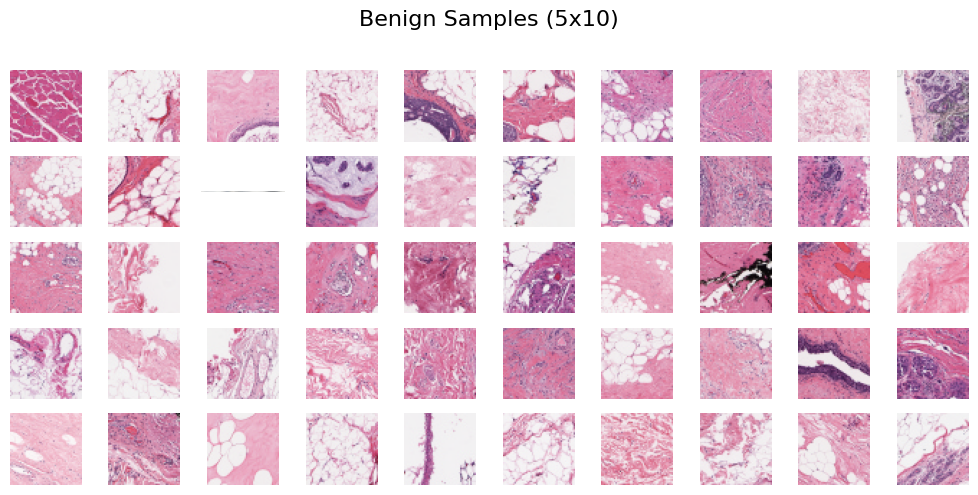

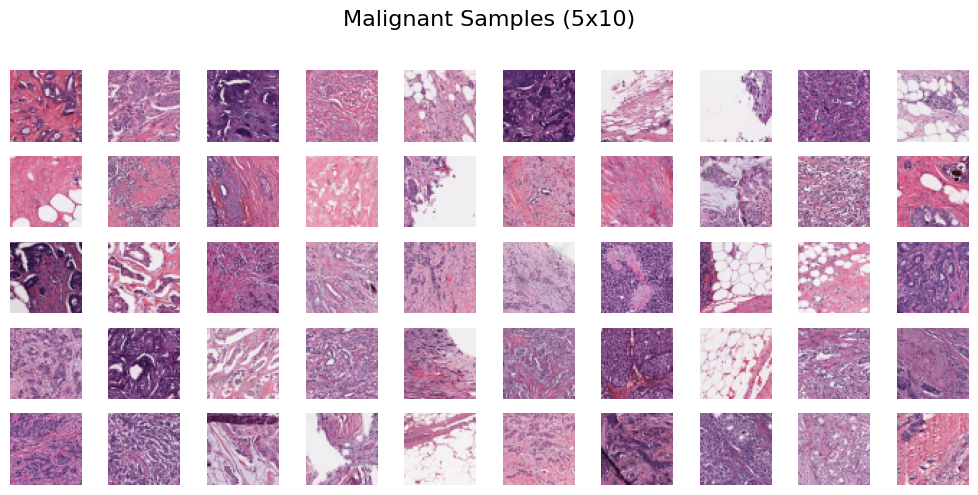

In [10]:
import matplotlib.pyplot as plt
import random
from PIL import Image

# Function to plot a montage of images
def plot_montage(paths, title, rows=5, cols=10):
    n = rows * cols
    sampled_paths = random.sample(paths, min(len(paths), n))
    
    plt.figure(figsize=(cols, rows))
    plt.suptitle(title, fontsize=16)
    
    for i, p in enumerate(sampled_paths):
        ax = plt.subplot(rows, cols, i + 1)
        img = Image.open(p)
        ax.imshow(img)
        ax.axis('off')
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# Prepare paths for each class
benign_paths    = df[df['label'] == 0]['path'].tolist()
malignant_paths = df[df['label'] == 1]['path'].tolist()

# Plot montages
plot_montage(benign_paths,    "Benign Samples (5x10)",    rows=5, cols=10)
plot_montage(malignant_paths, "Malignant Samples (5x10)", rows=5, cols=10)

Color : We notice that the malignant samples are darker than the other class, so to make sur of this hypothesis, let's see the distribution of the RGB colors for both classes. (Color-channel histograms).

Tissue architecture : In the benign grid you see broad, open spaces white bubbles, however the malignant class shows elements that are more crowded with fewer open spaces.

#### Color‐channel histograms

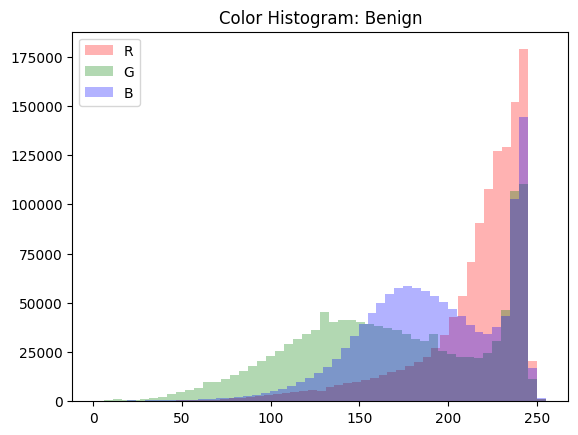

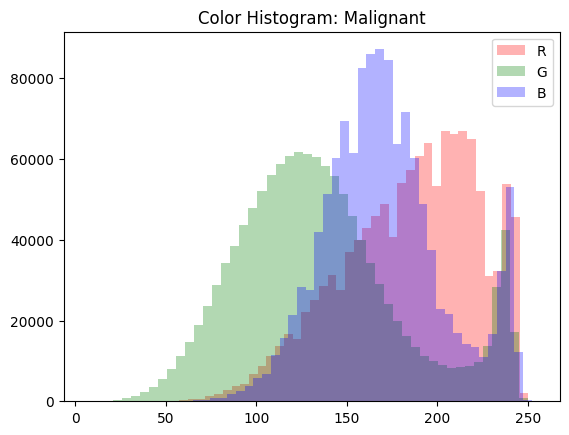

In [11]:
import numpy as np

def plot_color_hist(paths, title, n=500):
    samples = random.sample(paths, min(len(paths), n))
    pixels = np.vstack([np.array(Image.open(p)).reshape(-1,3) for p in samples])
    colors = ('r','g','b')
    plt.figure()
    for i, col in enumerate(colors):
        plt.hist(pixels[:,i], bins=50, alpha=0.3, color=col, label=col.upper())
    plt.title(title)
    plt.legend()
    plt.show()

plot_color_hist(benign_paths,    "Color Histogram: Benign")
plot_color_hist(malignant_paths, "Color Histogram: Malignant")

The histogram confirms what we said.

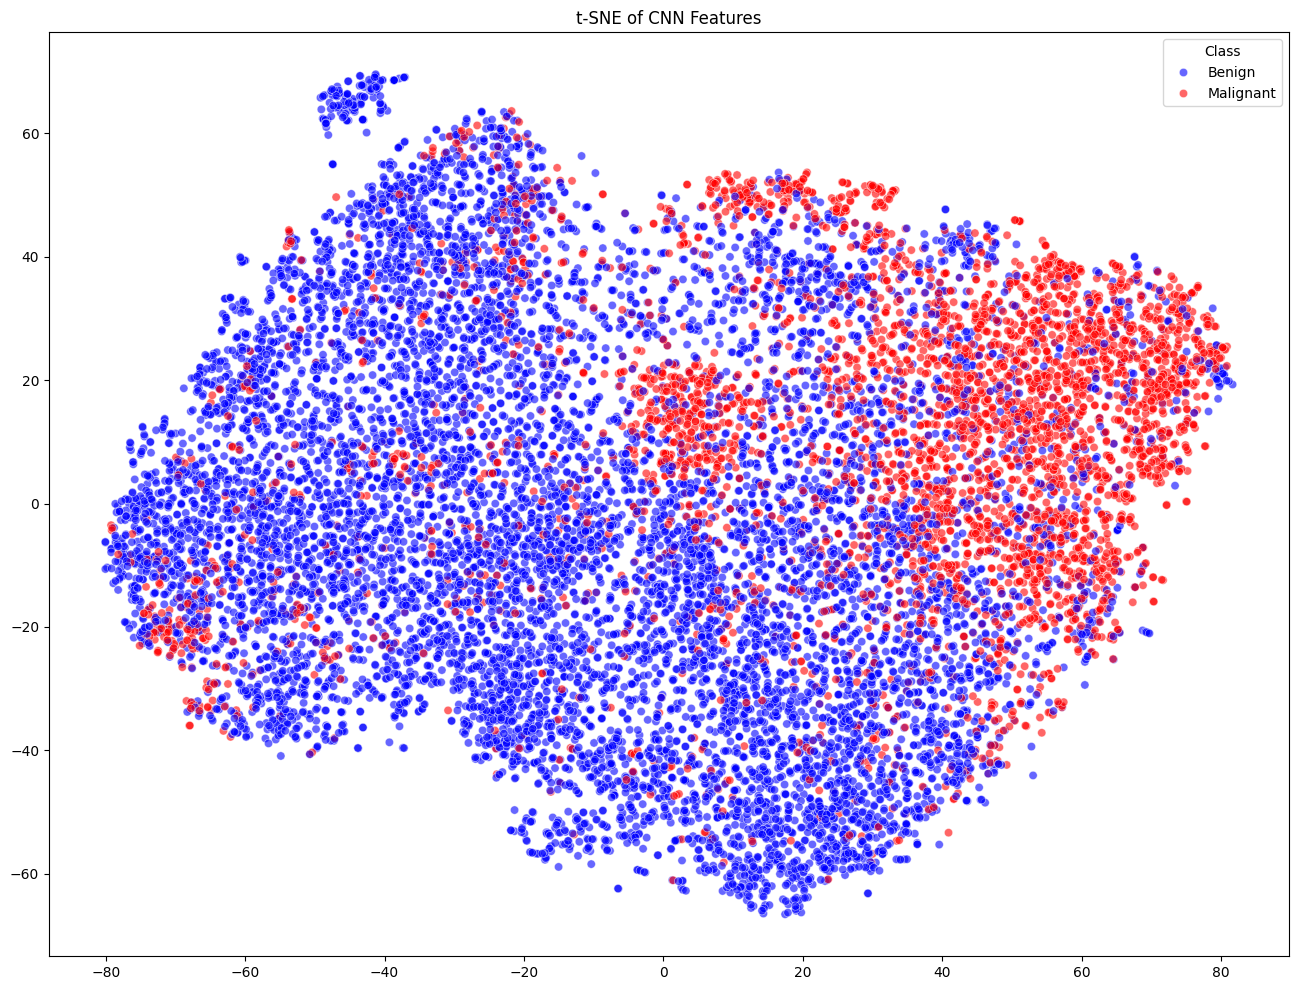

In [ ]:
import numpy as np
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming `feats` and `subset` are already defined
# 1) Run t-SNE
tsne = TSNE(n_components=2, random_state=42)
emb  = tsne.fit_transform(feats)

# 2) Map labels to strings and define an explicit palette
subset['label_str'] = subset['label'].map({0: 'Benign', 1: 'Malignant'})
palette = {'Benign': 'blue', 'Malignant': 'red'}

# 3) Plot
plt.figure(figsize=(16,12))
sns.scatterplot(
    x=emb[:,0], y=emb[:,1],
    hue=subset['label_str'],
    palette=palette,
    alpha=0.6
)
plt.title("t-SNE of CNN Features")
plt.legend(title="Class")
plt.show()


The t-SNE projection reveals two main clusters—benign patches (blue) mostly on the left and malignant patches (red) on the right—showing that the CNN’s features effectively separate the classes. Between these clusters lies a central overlap of mixed blue and red points, highlighting the patches the model struggles with most. Investigating these ambiguous samples could uncover subtle histological patterns and if addressed, might further improve classification performance.

## Modeling

In [15]:
def build_cnn(input_shape=(*IMG_SIZE,3), base_filters=32, dropout_rate=0.5):
    model = models.Sequential([
        layers.Input(input_shape),
        # Block 1
        layers.Conv2D(base_filters, (3,3), activation='relu', padding='same'),
        layers.Conv2D(base_filters, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(dropout_rate/2),
        # Block 2
        layers.Conv2D(base_filters*2, (3,3), activation='relu', padding='same'),
        layers.Conv2D(base_filters*2, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(dropout_rate),
        # Block 3
        layers.Conv2D(base_filters*4, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(dropout_rate),
        # Head
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(dropout_rate),
        layers.Dense(1, activation='sigmoid')
    ], name="IDC_CNN")
    return model

model = build_cnn()
model.compile(
    optimizer=optimizers.Adam(1e-4),
    loss='binary_crossentropy',
    metrics=[
        metrics.Recall(name='recall'),
        metrics.Precision(name='precision'),
        metrics.AUC(name='auc'),
        metrics.AUC(name='pr_auc', curve='PR')
    ]
)
model.summary()

Model: "IDC_CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 50, 50, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 50, 50, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 25, 25, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 25, 25, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 25, 25, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 25, 25, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 729,505 (2.78 MB)

 Trainable params: 729,505 (2.78 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
import numpy as np
from sklearn.metrics import precision_recall_curve, recall_score, precision_score

# 1) Gather all true labels and predicted scores on val_ds
y_true = []
y_scores = []
for imgs, labs in val_ds:
    y_true.append(labs.numpy())
    y_scores.append(model.predict(imgs).ravel())
y_true = np.concatenate(y_true)
y_scores = np.concatenate(y_scores)

# 2) Compute precision, recall at all thresholds
precisions, recalls, thresholds = precision_recall_curve(y_true, y_scores)

# 3) Find the lowest threshold that gives recall ≥ target_recall
target_recall = 0.99
# we need recalls[:-1] because precision_recall_curve returns one extra point
valid_idxs = np.where(recalls[:-1] >= target_recall)[0]
if len(valid_idxs)==0:
    print(f"No threshold achieves recall ≥ {target_recall}")
else:
    # pick the threshold with highest precision among those
    best_idx = valid_idxs[np.argmax(precisions[valid_idxs])]
    best_thresh = thresholds[best_idx]
    best_prec  = precisions[best_idx]
    best_rec   = recalls[best_idx]
    print(f"Chosen threshold: {best_thresh:.4f}")
    print(f"  Recall @ this thresh:    {best_rec:.3f}")
    print(f"  Precision @ this thresh: {best_prec:.3f}")

    # 4) (Optional) Evaluate on val set using this cutoff
    y_pred = (y_scores >= best_thresh).astype(int)
    print("\nValidation metrics at tuned threshold:")
    print("  Recall:   ", recall_score(y_true, y_pred))
    print("  Precision:", precision_score(y_true, y_pred))
    print("best thresh:", best_thresh)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━

2025-05-05 07:23:19.530002: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


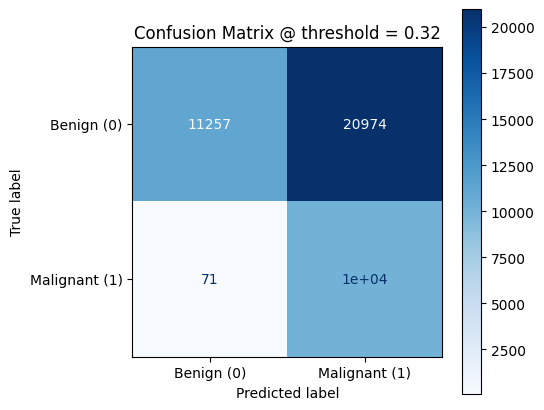

True Negatives (benign correctly filtered out): 11257
False Positives (benign flagged as malignant):   20974
False Negatives (malignant missed):            71
True Positives (malignant correctly flagged):  10080


In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 1) Collect true labels and predicted probabilities on test_ds
y_true = []
y_scores = []
for imgs, labs in test_ds:
    y_true.append(labs.numpy())
    y_scores.append(model.predict(imgs).ravel())
y_true = np.concatenate(y_true)
y_scores = np.concatenate(y_scores)

# 2) Binarize predictions at your chosen threshold (e.g. 0.5 or your tuned best_thresh)
y_pred = (y_scores >= best_thresh).astype(int)

# 3) Compute confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=[0,1])
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=['Benign (0)', 'Malignant (1)']
)

# 4) Plot it
fig, ax = plt.subplots(figsize=(5,5))
disp.plot(ax=ax, cmap='Blues')
plt.title(f'Confusion Matrix @ threshold = {best_thresh:.2f}')
plt.show()

# 5) Optional: print raw counts
tn, fp, fn, tp = cm.ravel()
print(f"True Negatives (benign correctly filtered out): {tn}")
print(f"False Positives (benign flagged as malignant):   {fp}")
print(f"False Negatives (malignant missed):            {fn}")
print(f"True Positives (malignant correctly flagged):  {tp}")